In [160]:
import sys
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt
import importlib
import jetnet
import time
import h5py
import pickle
from scipy import stats

sys.path.append('..')
sys.path.append('../utils/')

# import custom libraries
import utils
import energyflow_torch as efT

importlib.reload(utils)
importlib.reload(efT)

print('imports done')

# to make plots show up even when matplotlib.use('agg') in one of the imports:
%matplotlib inline    

imports done


# prepare JetNet datasets for EPiC-GAN setup

In [161]:
### ADAPT JETNET FILEPATH and FILENAME: Download from JetNet150: https://doi.org/10.5281/zenodo.6975117 and JetNet30: https://doi.org/10.5281/zenodo.6975118
n_points = 150   #   30 or 150 (for plotting)

## ADAPT FOR DESIRED DATASET
path = '/beegfs/desy/user/buhmae/2_PointCloudGeneration/JetNet/'
# fname = 'g.hdf5'  # from Version 2.0    Gluons
# fname = 'q.hdf5'  # from Version 2.0   Quarks
# fname = 't.hdf5'  # from Version 2.0    Tops

# fname = 'g150.hdf5'   # JetNet150 Gluons
# fname = 'q150.hdf5'   # JetNet150 Quarks
fname = 't150.hdf5'   # JetNet150 Tops




## OUTPUT FILES FOR EPiC-GAN TRAINING
out_folder='./'
# outfile_prefix = 'gluon_jetnet30_'
# outfile_prefix = 'quark_jetnet30_'
# outfile_prefix = 'top_jetnet30_'

# outfile_prefix = 'gluon_jetnet150_'
# outfile_prefix = 'quark_jetnet150_'
outfile_prefix = 'top_jetnet150_'


save = True

In [162]:
f = h5py.File(path+fname, 'r')
print(f.keys())
data = f['particle_features']
data = np.array(data)
data.shape

<KeysViewHDF5 ['jet_features', 'particle_features']>


(177945, 150, 4)

In [163]:
# jetnet features: eta_rel, phi_rel, pt_rel, mask
# drop mask
data = data[...,0:3]

# now feature order: pt, eta, phi
data = data[...,[2,0,1]]
# shape [-1, 30, 3]
print(data.shape)

(177945, 150, 3)


In [164]:
# jetnet dataset centered first and cut then on the particle multiplicity
# here re-centering

centering = True
if centering:
    data = utils.center_jets(data)
    print('jets centered')

jets centered


In [165]:
np.random.seed(123)

# split randomly in training, test and validaton set (70, 15, 15%)
data = data[np.random.permutation(len(data))]   # shuffle
data_train = data[:int(0.7*len(data))]
data_test = data[int(0.7*len(data)):int(0.85*len(data))]
data_val = data[int(0.85*len(data)):]
print('training set: ', len(data_train))
print('test set: ', len(data_test))
print('validaton set: ', len(data_val))
print('dataset train shape: ', data_train.shape)


training set:  124561
test set:  26692
validaton set:  26692
dataset train shape:  (124561, 150, 3)


In [166]:
f_train = out_folder + outfile_prefix + '_train.npy'
f_test = out_folder + outfile_prefix + '_test.npy'
f_val = out_folder + outfile_prefix + '_val.npy'


if save:
    np.save(f_train, data_train)
    np.save(f_test, data_test)
    np.save(f_val, data_val)
    print('files saved')

files saved


# KDE of particle multiplicity from training set

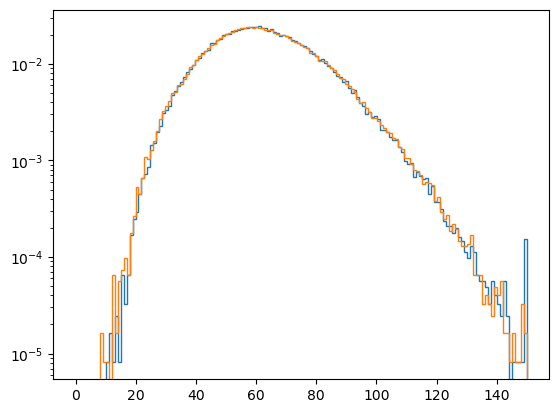

In [167]:
# calculate particle multiplicity
data_mults = utils.jet_mults(data_train)

# create kde pdf from datset x (kernel)
kde = stats.gaussian_kde(data_mults)
# resample from kde pdf (kernel)
x_kde = kde.resample(len(data_mults)).flatten()

# plotting
plt.clf()
hist = plt.hist(data_mults, bins=n_points+1, label='dataset', density=1, histtype='step',range=[0,n_points])
plt.hist(x_kde, bins=hist[1], label='resampled', density=1, histtype='step')

# s = np.linspace(hist[1][0], hist[1][-1], 1000)
# plt.plot(s,kde(s), label='kde pdf')
plt.yscale('log')
# plt.ylim(1e-5,)

plt.show()

In [168]:
## save kde

f_kde = out_folder + outfile_prefix + '_mults_kde.pkl'

if save:
    with open(f_kde, 'wb') as f:
        pickle.dump(kde, f)
    print('kde saved')

kde saved


# visualise training data

In [169]:
# data variables

data_ms = utils.jet_masses(data_train)
data_pts = utils.jet_pts(data_train)
data_ys = utils.jet_ys(data_train)
data_etas = utils.jet_etas(data_train)
data_phis = utils.jet_phis(data_train)
data_mults = utils.jet_mults(data_train)

<Figure size 640x480 with 0 Axes>

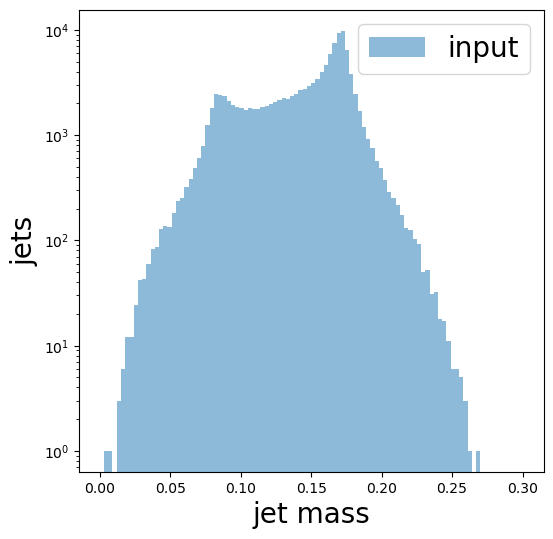

<Figure size 640x480 with 0 Axes>

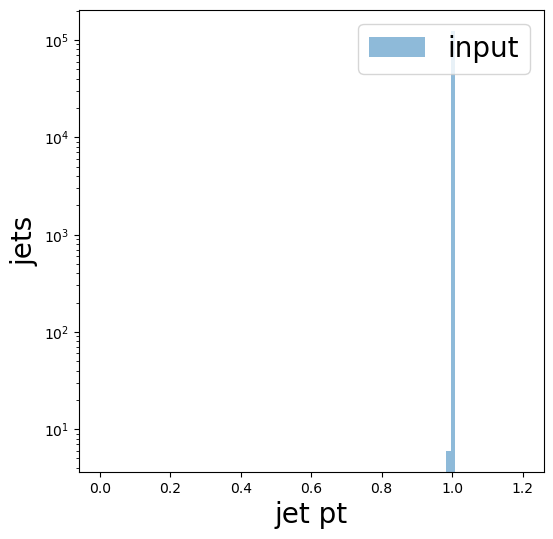

<Figure size 640x480 with 0 Axes>

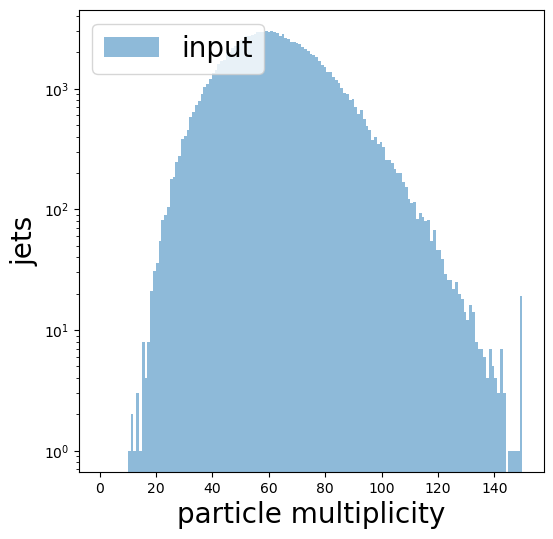

<Figure size 640x480 with 0 Axes>

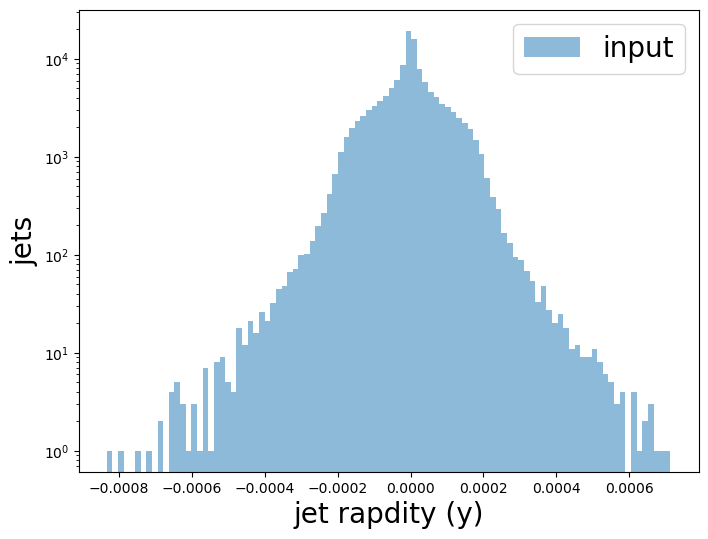

<Figure size 640x480 with 0 Axes>

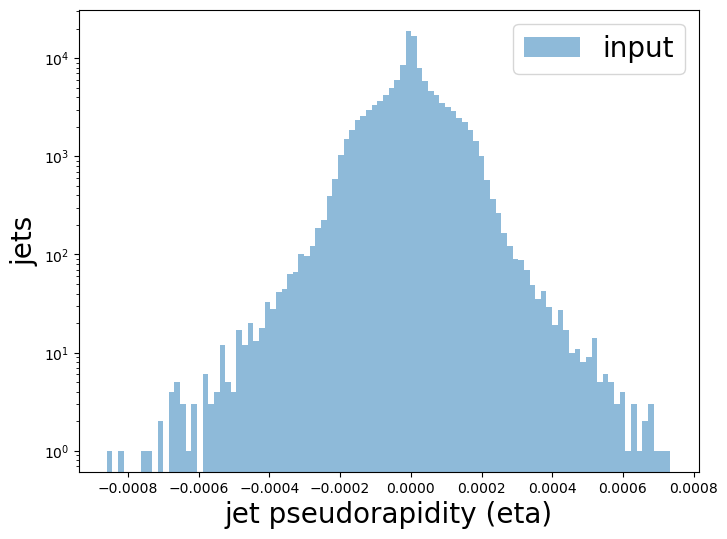

<Figure size 640x480 with 0 Axes>

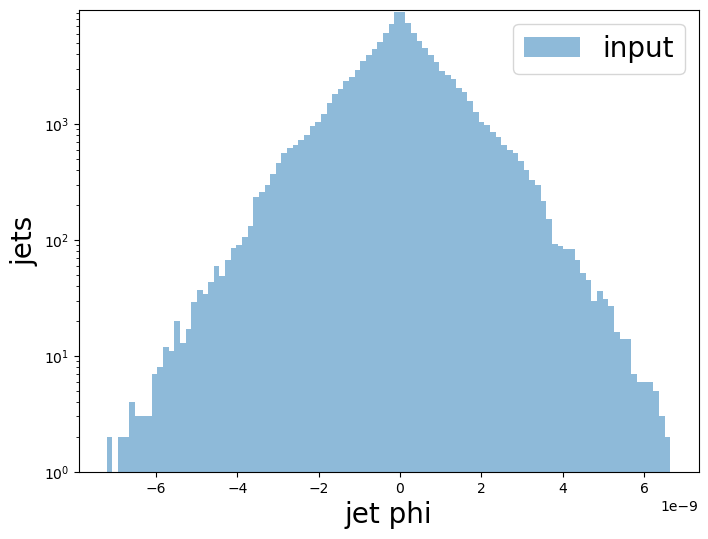

In [170]:
# plot jet level histograms
plt.clf()
plt.figure(figsize=(6,6), facecolor='none')
hist1 = plt.hist(data_ms, bins=100, label='input', histtype='stepfilled',alpha=0.5, range=[0,0.3])
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet mass', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(6,6), facecolor='none')
hist1 = plt.hist(data_pts, bins=100, label='input', histtype='stepfilled',alpha=0.5, range=[0.,1.2])
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet pt', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.yscale('log')
#plt.xlim(0.5, 1.3)
plt.show()

plt.clf()
plt.figure(figsize=(6,6), facecolor='none')
hist1 = plt.hist(data_mults, bins=n_points+1, label='input', histtype='stepfilled',alpha=0.5, range=[0,n_points])
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('particle multiplicity', fontsize=20)
plt.yscale('log')
plt.ylabel('jets', fontsize=20)
plt.show()

plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
hist1 = plt.hist(data_ys, bins=100, label='input', histtype='stepfilled',alpha=0.5)
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet rapdity (y)', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
hist1 = plt.hist(data_etas, bins=100, label='input', histtype='stepfilled',alpha=0.5)
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet pseudorapidity (eta)', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
hist1 = plt.hist(data_phis, bins=100, label='input', histtype='stepfilled',alpha=0.5)#, range=[-1,7])
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('jet phi', fontsize=20)
plt.ylabel('jets', fontsize=20)
plt.ylim(1,)
plt.yscale('log')
plt.show()

<Figure size 640x480 with 0 Axes>

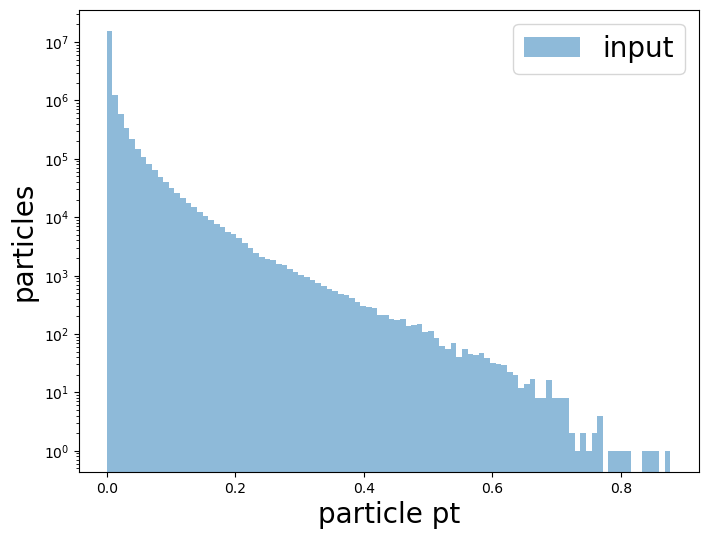

<Figure size 640x480 with 0 Axes>

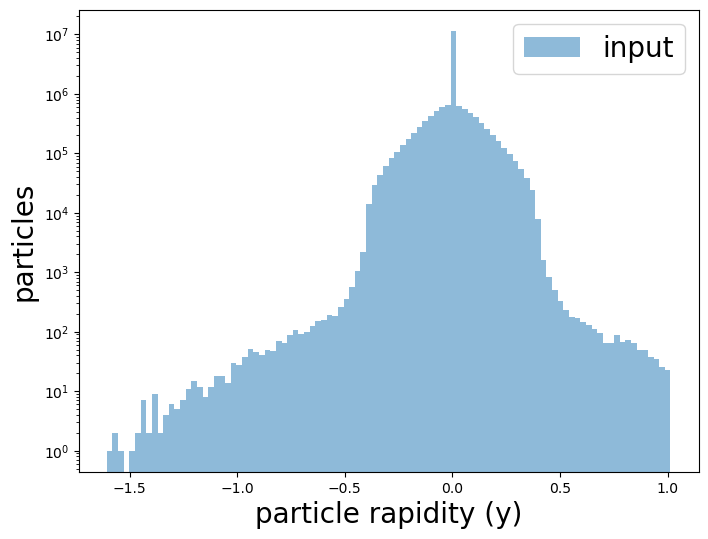

<Figure size 640x480 with 0 Axes>

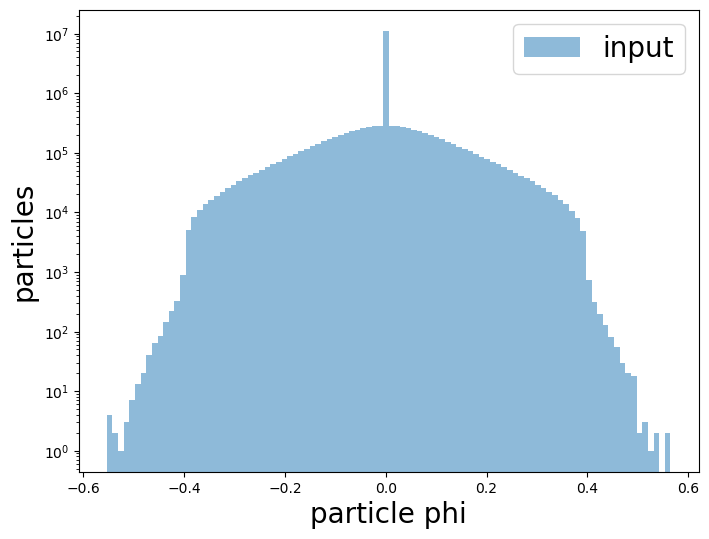

In [171]:
# plot particle level histograms

plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
x_min, x_max = np.array([data_train[:,:,0].flatten().min(), data_train[:,:,0].flatten().min()]).min(), np.array([data_train[:,:,0].flatten().max(), data_train[:,:,0].flatten().max()]).max()
hist1 = plt.hist(data_train[:,:,0].flatten(), bins=100, label='input', histtype='stepfilled', range=[x_min,x_max], alpha=0.5)#, range=[-100,600])
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('particle pt', fontsize=20)
plt.ylabel('particles', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
x_min, x_max = np.array([data_train[:,:,1].flatten().min(), data_train[:,:,1].flatten().min()]).min(), np.array([data_train[:,:,1].flatten().max(), data_train[:,:,1].flatten().max()]).max()
hist1 = plt.hist(data_train[:,:,1].flatten(), bins=100, label='input', histtype='stepfilled', range=[x_min,x_max], alpha=0.5)
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('particle rapidity (y)', fontsize=20)
plt.ylabel('particles', fontsize=20)
plt.yscale('log')
plt.show()

plt.clf()
plt.figure(figsize=(8,6), facecolor='none')
x_min, x_max = np.array([data_train[:,:,2].flatten().min(), data_train[:,:,2].flatten().min()]).min(), np.array([data_train[:,:,2].flatten().max(), data_train[:,:,2].flatten().max()]).max()
hist1 = plt.hist(data_train[:,:,2].flatten(), bins=100, label='input', histtype='stepfilled', range=[x_min,x_max], alpha=0.5)
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('particle phi', fontsize=20)
plt.ylabel('particles', fontsize=20)
plt.yscale('log')
plt.show()